# Graphing Writing Progress, Keystroke and CoCoGen Measures

In [2]:
# Imports
import sys
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import random
import math
import statistics
import scipy
import csv

# Configs
%config InlineBackend.figure_format ='retina'
%matplotlib inline

# Cython
%load_ext Cython
#!python
#cython: language_level=3

print("All libraries set-up and ready to go!")

All libraries set-up and ready to go!


CSV LOADING CELL:

In [58]:
suffix = ''
k = pd.read_csv('../../pads/keystrokes' + suffix + '.csv', index_col=False, encoding='latin1')
w = pd.read_csv('../../pads/words' + suffix + '.csv', index_col=False)
s = pd.read_csv('../../pads/sentences' + suffix + '.csv', index_col=False)
f = pd.read_csv('../../pads/files' + suffix + '.csv', index_col=False)
u = pd.read_csv('../../pads/users' + suffix + '.csv', index_col=False)
p = pd.read_csv('../../pads/pcc' + suffix + '.csv', index_col=False)

# Plotting writing process by file, user

Graphs display normalized position vs. normalized time for a file, with each line representing the progress of a sentence, or normalized position vs. normalized time for a user, with each line representing the progess of a file.

This can be used to visualize a writer's writing process and to see if their writing style is consistent or if it differs by sentence or file.

REQUIRES: list of x-values, list of y-values (typically normalized time, normalized position)

EFFECTS: graphs y vs. x in line graph

In [4]:
#plots pos vs. time line
#input is list of normalized (time, pos) tuples 
def draw_line(x_vals, y_vals):
    plt.plot(x_vals, y_vals, color='b', alpha=0.1)
    #plt.show()

REQUIRES: sentence id

EFFECTS: returns list of normalized times and positions (between 0 and 1) for sentence 's_id'.
        These normalized lists are used to plot position vs. time graph by sentence.

In [5]:
#normalize time and position lists for a sentence
#ORIGINAL VERSION
def normalize_time_pos(s_id):
    global k, s
    time_pos_list = []
    normalized_times = []
    normalized_positions = []
    #using max - min for total solves out-of-order sentences
    total_time = k[k.s_id == s_id]['end_t'].max() - k[k.s_id == s_id]['end_t'].min()
    total_len = s.loc[s_id, 'text_len']
    #start_time is time stamp of earliest keystroke in sentence
    start_time = k[k.s_id == s_id]['end_t'].min()
    #start_pos is FIRST keystroke in sentence by location
    start_pos = s.loc[s_id, 'start_pos']
    normalized_times = list((k[k.s_id == s_id]['end_t'] - start_time) / total_time)
    normalized_positions = list((k[k.s_id == s_id]['pos'] - start_pos) / total_len)
    return (normalized_times, normalized_positions)

REQUIRES: file id

EFFECTS: returns normalized time and position lists (between 0 and 1) for entire file.
        These lists are used to plot position vs. time by file.

In [6]:
#normalize time and position lists for a file
#file version
def normalize_time_pos_file(f_id):
    global k, s
    #total_len = len(k[k.f_id == f_id])
    total_len = k[k.f_id == f_id]['pos'].max() - k[k.f_id == f_id]['pos'].min()
    total_time = k[k.f_id == f_id]['end_t'].max() - k[k.f_id == f_id]['end_t'].min()
    start_time = k[k.f_id == f_id]['end_t'].min()
    start_sent = f.loc[f_id, 's_id_s']
    start_pos = int(s[s.id == start_sent]['start_pos'])
    normalized_times = list((k[k.f_id == f_id]['end_t'] - start_time) / total_time)
    normalized_positions = list((k[k.f_id == f_id]['pos'] - start_pos) / total_len)
    #print(k[k.f_id == f_id]['pos'].min(), start_pos, total_len)
    return (normalized_times, normalized_positions)

REQUIRES: file id

EFFECTS: for each sentence in given file, first normalizes times and positions, then plots normalized position vs. normalized time. Results in a position vs. time graph where each line represents the progress of a sentence.

In [7]:
#plot all sentences in files as pos vs. time lines
def plot_file_by_sentence(f_id):
    sentences_in_file = list(s[s.f_id == f_id]['id'])
    for index in sentences_in_file:
        x_vals, y_vals = normalize_time_pos(index)
        draw_line(x_vals, y_vals)
        plt.xlabel('time')
        plt.ylabel('position')
        title = 'Position vs. Time for all sentences in File ' + str(f_id)
        plt.title(title)
    plt.show()

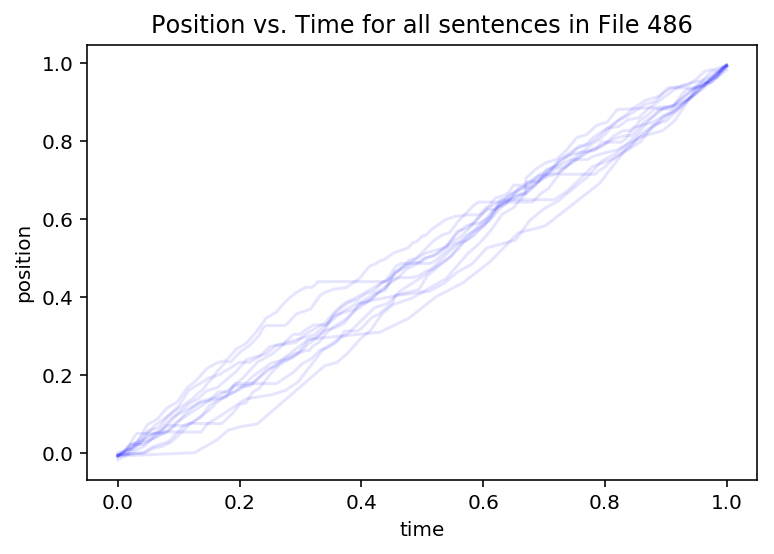

In [8]:
#used in paper section 2.3
plot_file_by_sentence(486)

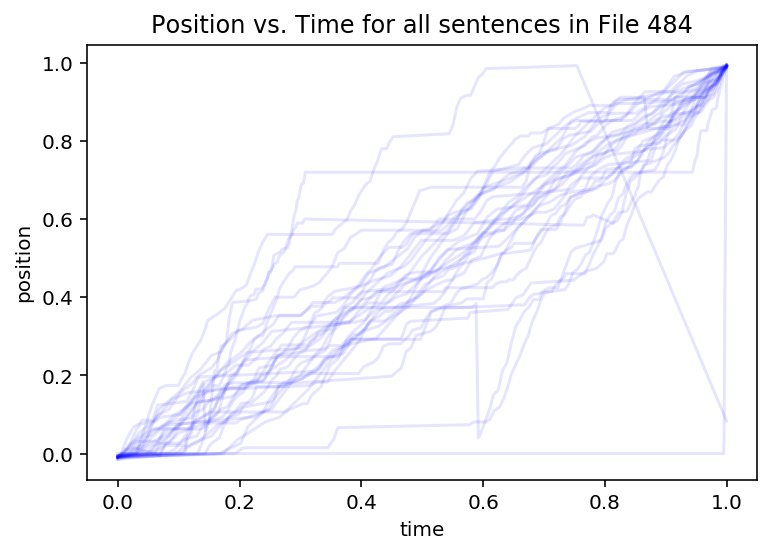

In [9]:
#used in paper section 2.3
plot_file_by_sentence(484)

REQUIRES: user id 

EFFECTS: for each file by given user, first normalizes times and positions, then plots normalized position vs. normaized time. Results in a position vs. time graph where each line represents the progress of a file.

In [10]:
#plot all files in user as pos vs. time lines
def plot_user_by_file(u_id):
    files_by_user = list(f[f.u_id == u_id]['id'])
    for index in files_by_user:
        x_vals, y_vals = normalize_time_pos_file(index)
        draw_line(x_vals, y_vals)
    plt.xlabel('time')
    plt.ylabel('position')
    title = 'Position vs. Time for all files by User ' + str(u_id)
    plt.title(title)
    #plt.show()

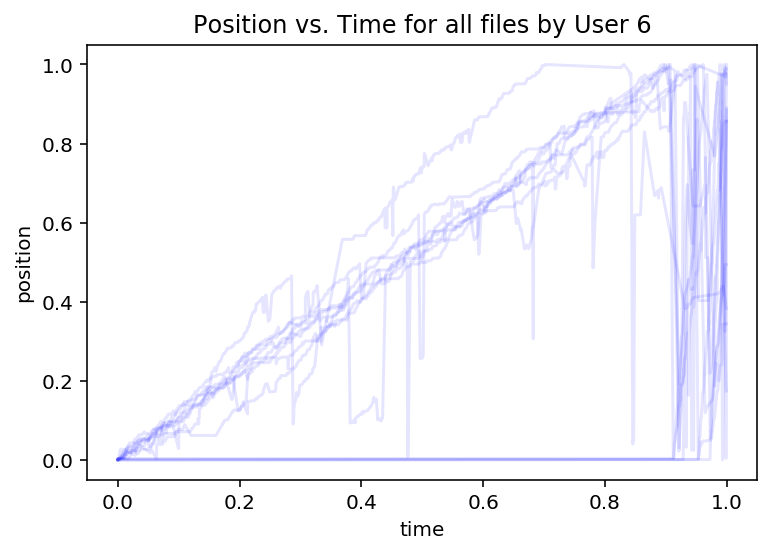

In [11]:
#used in paper section 2.3
plot_user_by_file(6)

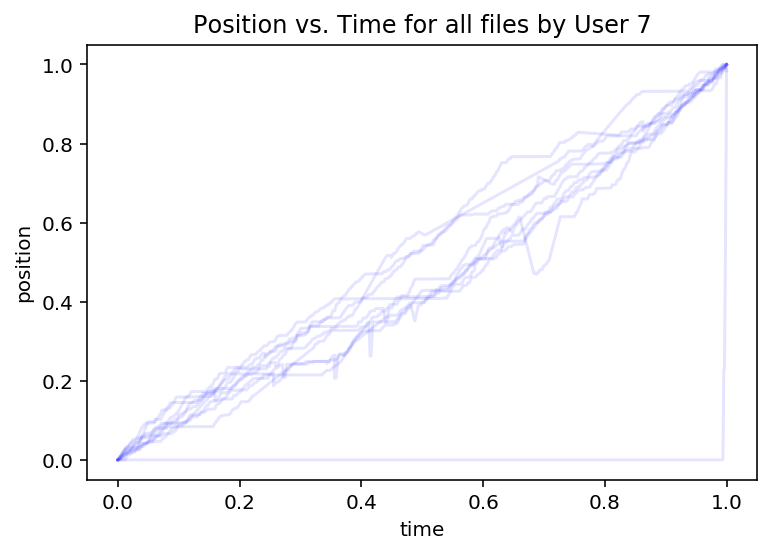

In [12]:
#used in paper section 2.3
plot_user_by_file(7)

## Plotting CocoGen vs. Keystroke Measures

Individually plots the curves of two measures over time in each of a user's files to visualize the relation between the two traits.

Also produces dictionary of Pearson correlation coefficients for measure pairs that can be stored as dataframe or csv.

In [18]:
#list of all cocogen measures
COCOGEN_MEASURES = ['Syntactic.ClausesPerSentence_value',
       'Syntactic.DependentClausesPerSentence_value',
       'Syntactic.CoordinatePhrasesPerSentence_value',
       'Syntactic.VerbPhrasesPerSentence_value',
       'Syntactic.ComplexNominalsPerSentence_value',
       'NounPhrasePreModificationWords_value',
       'NounPhrasePostModificationWords_value',
       'Lexical.Sophistication.NAWL_value',
       'Lexical.Sophistication.NGSL_value', 'Lexical.Sophistication.AFL_value',
       'Lexical.Sophistication.ANC_value', 'Lexical.Sophistication.BNC_value',
       'Lexical.Density_value', 'Lexical.Diversity.NDW_value',
       'Lexical.Diversity.CNDW_value', 'Lexical.Diversity.TTR_value',
       'Lexical.Diversity.CTTR_value', 'Lexical.Diversity.RTTR_value',
       'Morphological.MeanSyllablesPerWord_value',
       'Morphological.MeanLengthWord_value', 'KolmogorovDeflate_value',
       'Morphological.KolmogorovDeflate_value',
       'Syntactic.KolmogorovDeflate_value']

REQUIRES: y = list of y values to be plotted; window_size = size of sliding window to average y-values

EFFECTS: Uses sliding averages to average each consecutive group of *window_size* y-values to result in fewer large jumps when data is plotted.

In [19]:
#replace each value with average value of next *window_size* points to get smoother curve
def smooth_points(y, window_size):
    new_y = []
    for i in range(len(y) - window_size):
        new_y.append(statistics.mean(y[i:i+window_size]))
    return new_y

REQUIRES: file id, (typically keystroke) measure, (typically CoCoGen) measure, window_size = number of y-values to be sliding averaged

EFFECTS: Plots measure1 as a line graph and measure2 as a bar graph to show the relationship between the two measures over time in the given file.

In [20]:
#plots line and bar graph for two given measures (one cocogen, one keystroke) for a given file
def plot_cocogen_contours(f_id, measure1, measure2, window_size):
    #get all sentences in file
    sent_list = s[s.f_id == f_id]
    text_len = len(sent_list)
    #x ticks are just normalized file position, adjusted by window_size to account for sliding averaged y-values
    x_axis = [i / (text_len - window_size) for i in range(text_len - window_size)]
    #average y-values by clusters of window_size
    y_measure1 = smooth_points(s[s.f_id == f_id][measure1], window_size)
    y_measure2 = smooth_points(s[s.f_id == f_id][measure2], window_size)
    #plot measure1 as line graph, measure2 as bar graph
    fig, ax = plt.subplots()
    p1, = plt.plot(x_axis, y_measure1, color='b', label=measure1)
    p2 = plt.bar(x_axis, y_measure2, color='c', width=0.025, label=measure2)
    plt.legend([p1, p2], [measure1, measure2])
    title = "Measures Over Time for File " + str(f_id)
    plt.title(title)
    plt.show()
    #return sliding average y-values
    return (y_measure1, y_measure2)

REQUIRES: user id, (typically keystroke) measure, (typically CoCoGen) measure, window_size = group size to sliding average y-values

EFFECTS: runs plot_cocogen_contours on each file by specified user. Results in a single graph for each file.

In [21]:
#plots individual contour comparison graphs for each file by a given user
def plot_all_file_contours_for_user(u_id, measure1, measure2, window_size):
    user_meas_diff = []
    for f_id in f[f.u_id == u_id]['id']:
        y1, y2 = plot_cocogen_contours(f_id, measure1, measure2, window_size)

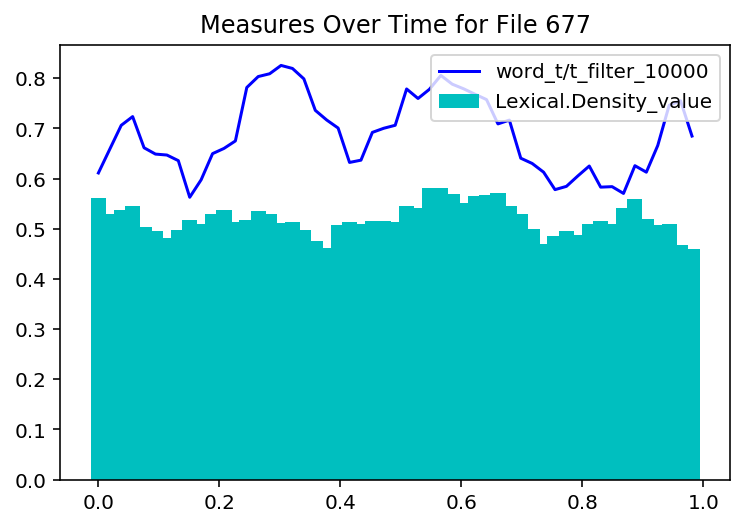

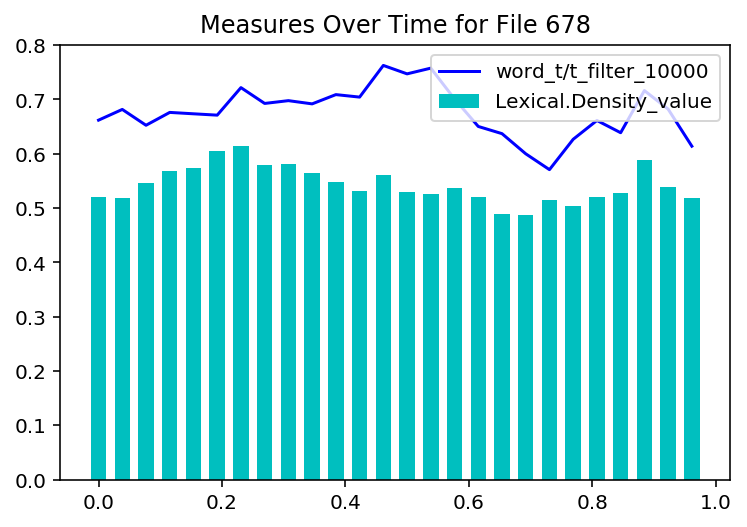

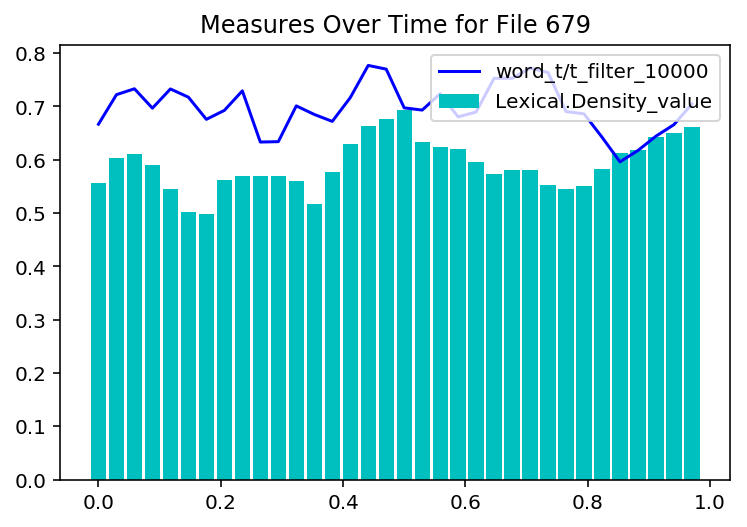

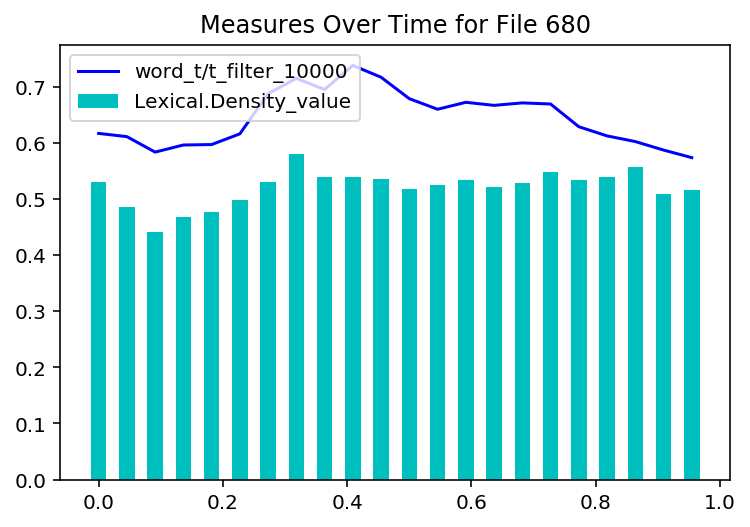

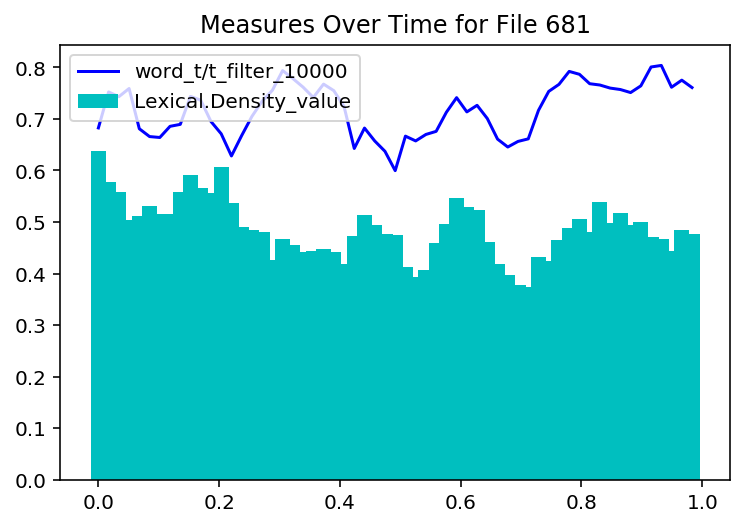

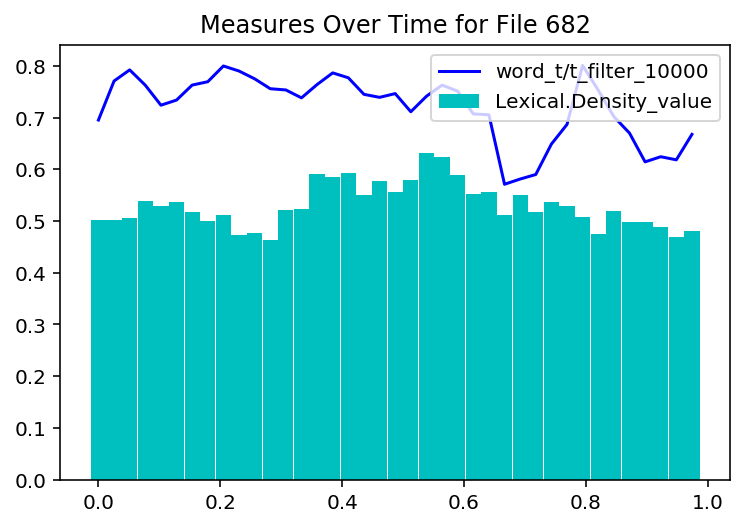

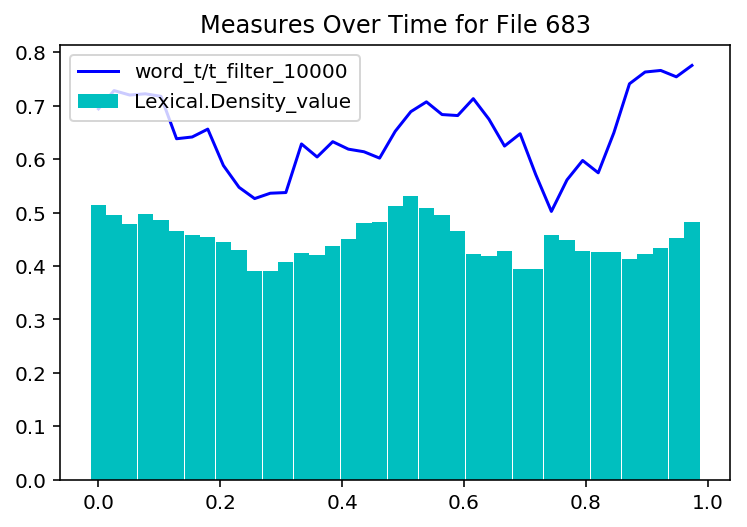

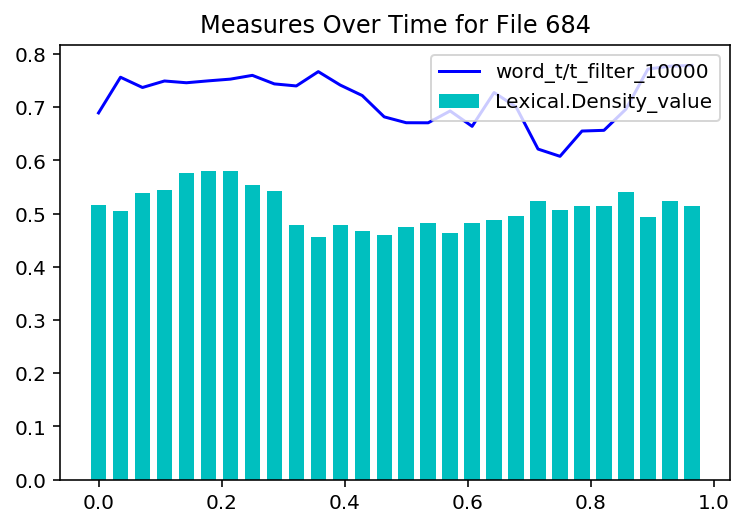

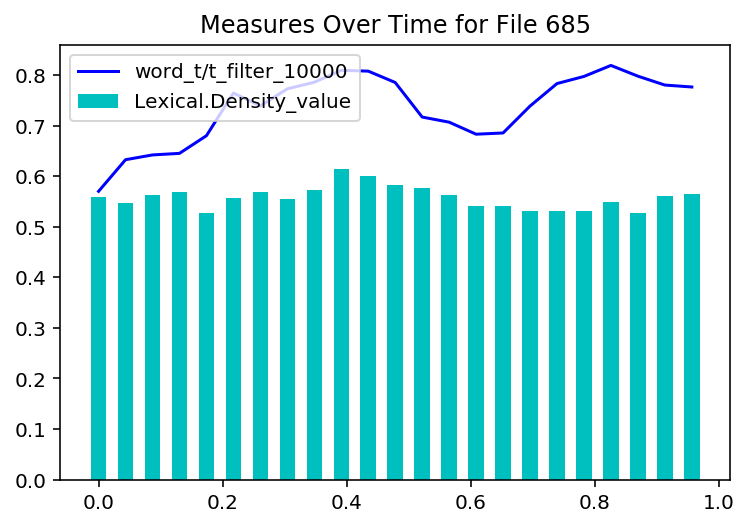

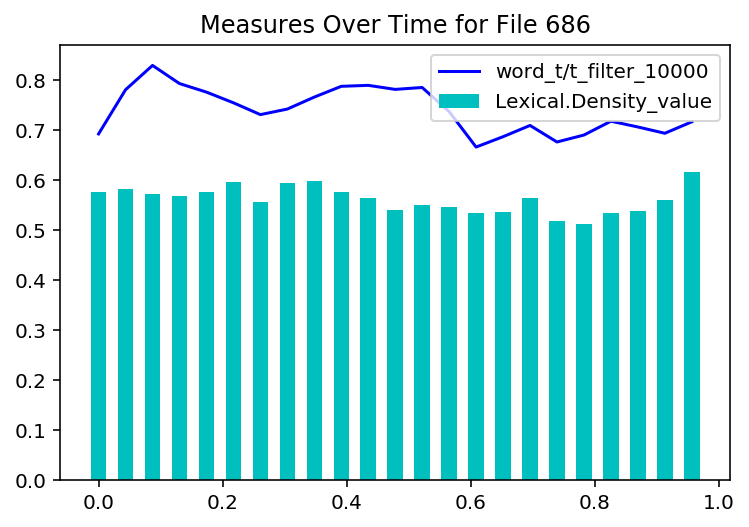

In [22]:
plot_all_file_contours_for_user(85, 'word_t/t_filter_10000', 'Lexical.Density_value', 5)

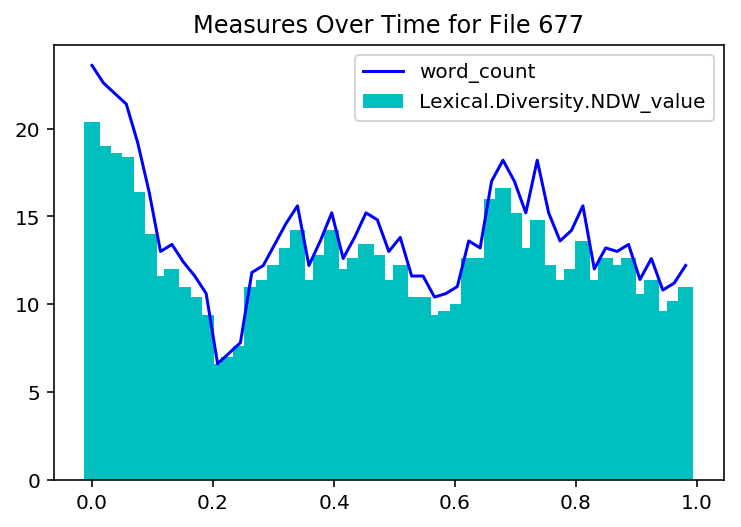

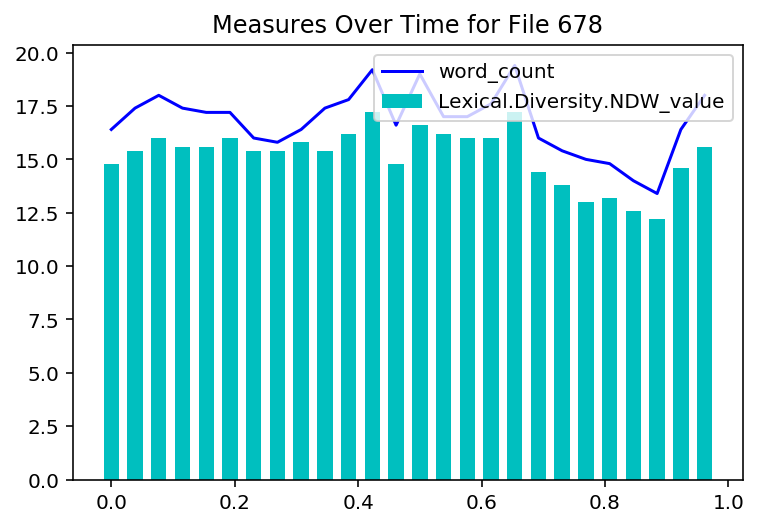

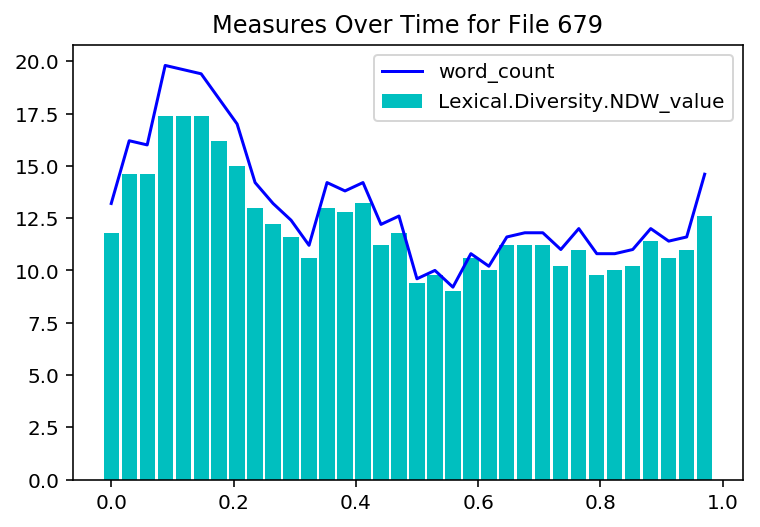

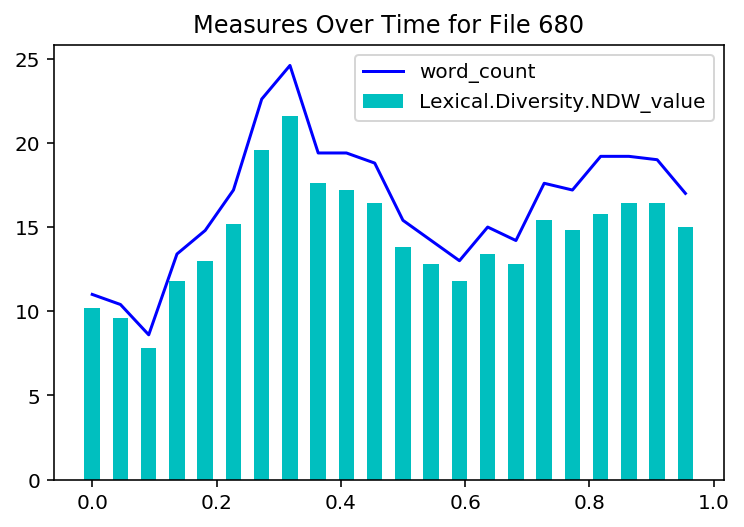

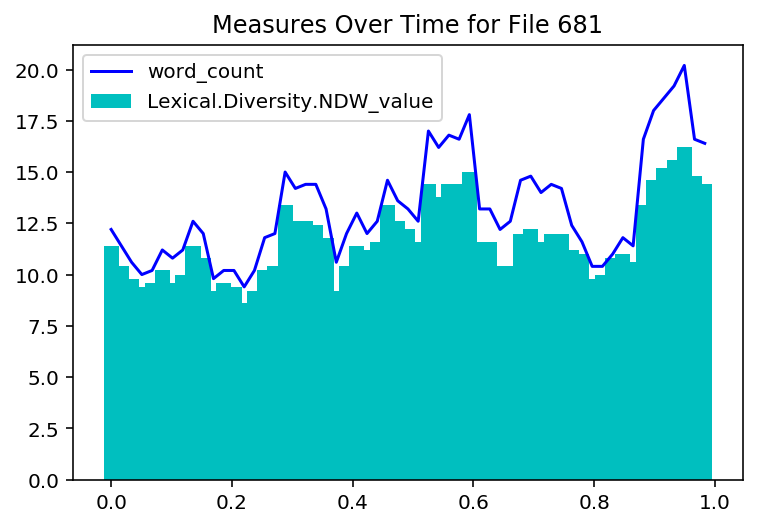

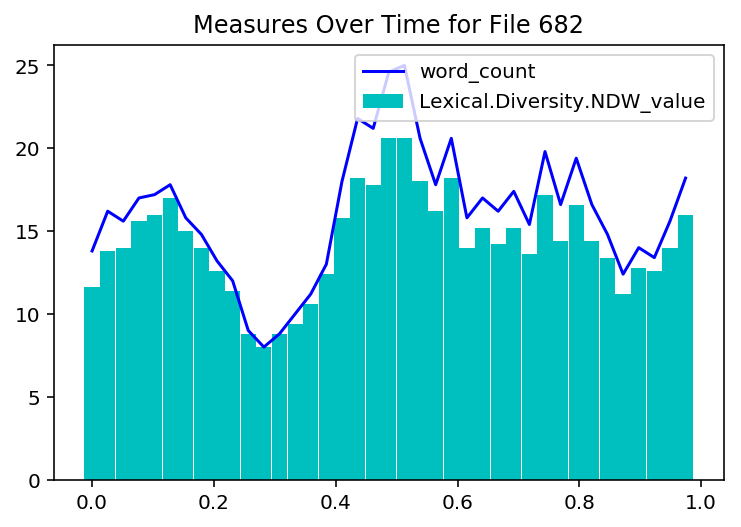

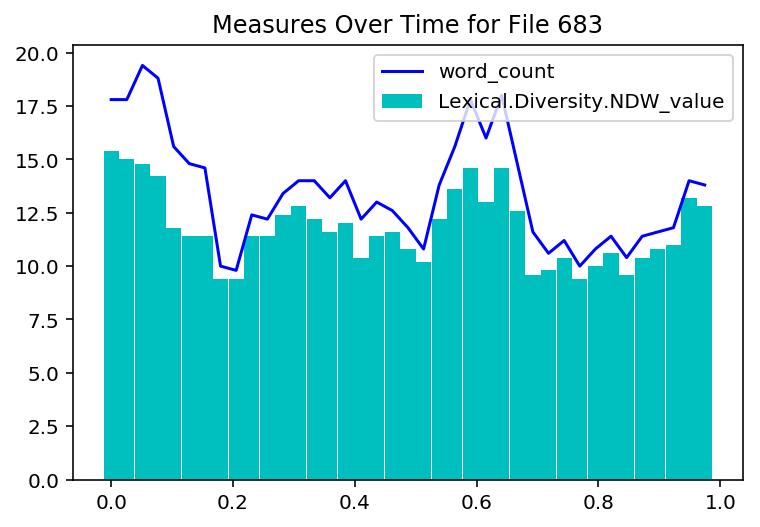

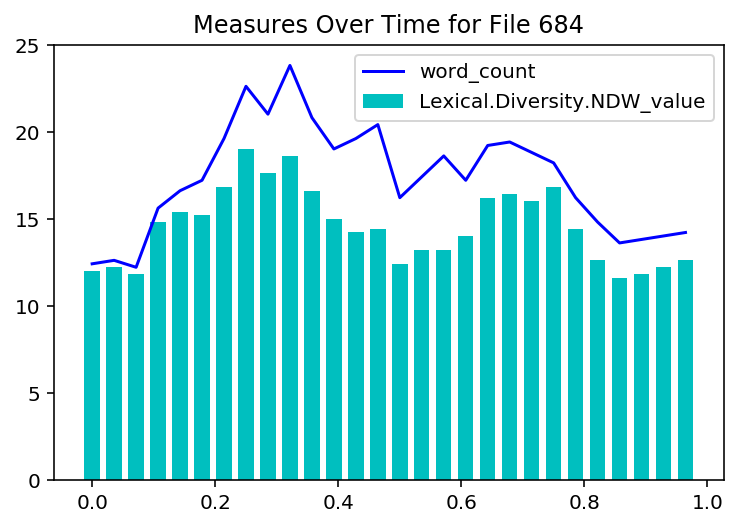

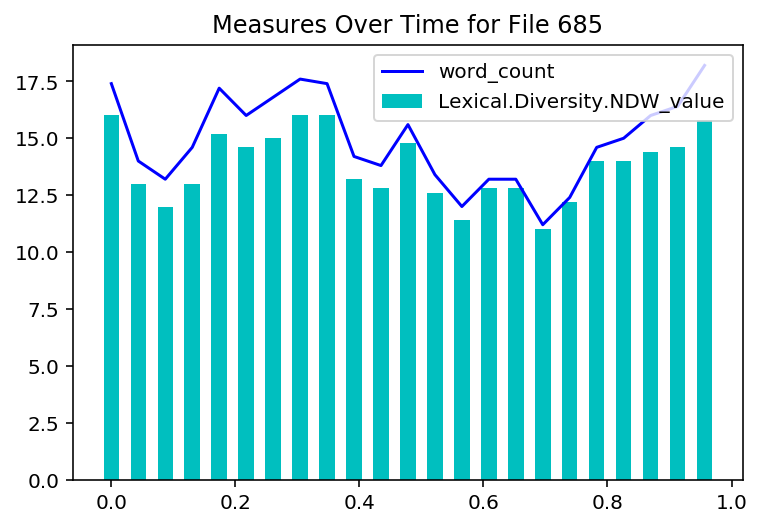

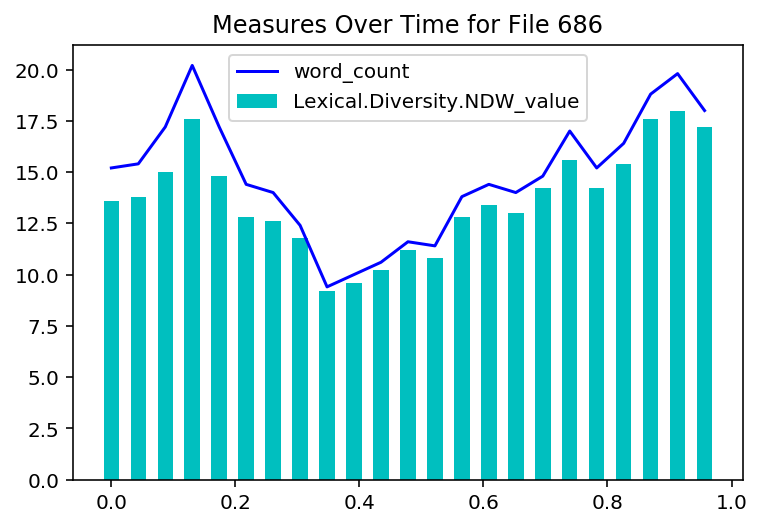

In [23]:
plot_all_file_contours_for_user(85, 'word_count', 'Lexical.Diversity.NDW_value', 5)

In [27]:
#returns Pearson Correlation Coefficient for two measures
def pcc(pop1, pop2):
    pair =  scipy.stats.pearsonr(pop1, pop2)
    return pair[0]

EFFECTS: returns list of Pearson Correlation Coefficient (by user) for a pair of measures over all users.

In [28]:
#compute all pcc-values by user, for 2 measures
def get_pcc_list(measure1, measure2, window_size):
    pcc_list = []
    for u_id in u.id:
        for f_id in f[f.u_id == u_id]['id']:
            pop1 = smooth_points(s[s.f_id == f_id][measure1], window_size)
            pop2 = smooth_points(s[s.f_id == f_id][measure2], window_size)
            pcc_list.append(pcc(pop1, pop2))
    cleaned_list = [x for x in pcc_list if str(x) != 'nan']
    return cleaned_list

In [24]:
#averages pcc's for all users for pair of measures
def get_pcc_avg(measure1, measure2, window_size):
    #compute pcc for pair of measures overa all users
    pcc_list = get_pcc_list(measure1, measure2, window_size)
    avg = statistics.mean(pcc_list)
    return avg

REQUIRES: KL_measure_list = list of strings of keystroke logging measures desired to be compared with all CoCoGen measures; window_size = size of window for y-values to be sliding averaged

EFFECTS: for each keystroke logging measure in given list, computes average Pearson Correlation Coefficient between keystroke and CoCoGen measures over all users. Results in 2D dictionary of form: {{KL_measure1: {CCG_1: pcc1}, {CCG_2: pcc2}, etc.}, etc.}

In [44]:
#takes about 15 minutes+ for 1 KL measure
def get_pcc_dict(KL_measure_list, window_size):
    base_dict = {}
    for base in KL_measure_list:
        avg_list = []
        for name in COCOGEN_MEASURES:
            avg_list.append(get_pcc_avg(base, name, window_size))
        base_dict[base] = avg_list

Note: once pcc values are computed for each pair of measures for each user, they were averaged and stored in dataframe. This was then written to pcc.csv, which can be loaded along with the other dataframes in the csv loading cell at the top. If pcc values of other measure pairs are desired, get_pcc_dict() must be run with list of desired KL measures. The resulting dictionary can be added to the existing p dataframe, then updated in the csv file using the cells below.

REQUIRES: dictionary of keystroke logging measure mapping to list of pcc values in order of COCOGEN_MEASURES (output of 'get_pcc_dict')

EFFECTS: adds new column(s) to pcc dataframe representing added keystroke logging measures.

In [73]:
def update_p(base_dict):
    for base_key in base_dict.keys():
        p[base_key] = base_dict[base_key]

In [78]:
#write updated pcc dataframe to csv in pads
p.to_csv('../../pads/pcc.csv', index=False)